# Mag-7 Concentration Analysis

This notebook analyzes the concentration of the *'Mag-7'* stocks in the S&P 500 and their impact on the index.
The Mag-7 is comprised of Alphabet (Google), Apple, Amazon, Meta, Microsoft, Nvidia, and Tesla.  As we'll see, these technology stocks carry an outsized weight on the **S&P 500** stock index that represents the largest U.S. publicly traded companies by market capitalization.

In [4]:
## Import the necessary libraries
import os                           # For file operations
import numpy as np                  # For numerical operations
import pandas as pd                 # For data manipulation
import matplotlib.pyplot as plt     # For visualization
from urllib.request import urlopen  # For fetching data from the web
import json                         # For reading / writing JSON files

For this analysis we'll look at market caps and price action for the index and the mag-7s since 2015.  It's important to note that the Mag-7 term was coined in 2023.  Previously there was a similar group of stocks called the *FANG's*, or *FAANG's* dating back to 2013 and 2017, respectively.  Since the Mag-7 are what's in the news at the moment, we are focusing on them.

In [6]:
## parameters
start_date = '2015-01-01'               # Start date for the analysis 
end_date = '2024-12-31'                 # End date for the analysis
sp500_symbol = '^GSPC'                  # S&P 500 index symbol
mag7_symbols = ['GOOG','AMZN','AAPL','META','MSFT','NVDA','TSLA']   # Magnificent 7 symbols
api_key = os.environ['FMP_KEY']         # FMP market data API key

### Obtaining the Data

**FMP** offers a convenient api to retrieve the data we need - namely historical prices, S&P 500 historical constituents, and historical market caps.  To reduce boiler plating, we use a function to make the api call.

Since we'll pull price history for multiple stocks and the index, we define wrap the fmp func with one that takes only the symbol (ticker) as an argument.

In [7]:
## function to get data from api.
def get_fmp_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

## get price history.
def get_price_history(ticker):
    url = f"https://financialmodelingprep.com/stable/historical-price-eod/full?symbol={ticker}&from={start_date}&to={end_date}&apikey={api_key}"
    return get_fmp_data(url)
sppa = get_price_history(sp500_symbol) ## S&P 500 price action

## get S&P 500 constituents.
url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={api_key}"
spc = get_fmp_data(url) ## current S&P 500 constituents

## get historical S&P 500 constituents.
url = f"https://financialmodelingprep.com/api/v3/historical/sp500_constituent?apikey={api_key}"
sphc = get_fmp_data(url) ## historical additions and removals

### Processing the Data

Data processing is the most involved phase of this analysis.  Starting with price action, the data sets received from FMP are daily OHLCV (open, high, low, close, volume).  We want to compute daily returns from the close prices and transform the data to monthly frequency.  For the Mag-7's we'll combine them into a single data set using *pd.concat*.

In [8]:
## process price data
def process_price_history(df):
    return (
        df                                                          # starting data frame
        .loc[:, ['date', 'close']]                                  # select date and close columns
        .assign(date = lambda x: pd.to_datetime(x.date))            # convert date to datetime
        .set_index('date')                                          # set date as index
        .sort_index(ascending=True)                                 # sort by date (oldest first)
        .assign(pctchg = lambda x: x.close.pct_change())            # calculate daily percentage change
        .dropna()                                                   # drop rows with missing values (first row)
        .resample('ME')                                             # resample by month end
        .agg({'close': 'last',                                      # get the last close price in the month
            'pctchg': lambda x: (1 + x).prod() - 1})                # calculate the monthly percentage change
        .reset_index()                                              # reset the index
        .assign(month = lambda df_: df_.date.dt.to_period('M'))     # extract the month
        .set_index('month')                                         # set the month as index
    )

sp500 = process_price_history(sppa)                                 # S&P 500 price action
mag7 = pd.concat([process_price_history(get_price_history(ticker)).loc[:,['pctchg']].rename(columns={'pctchg':ticker}) \
                  for ticker in mag7_symbols], axis=1)              # Magnificent 7 price action

Getting the S&P 500 constituents is a little more involved.  The FMP data is formatted as follows: The current constituents are essentially a list of stock tickers, while the historical data set is a change log of the additions and removals over time.  
The approach we're taking is to start with the most current list of stocks in the index, and then work backwards one month at at time using the historical changes.  Anchoring on beginning of month dates, each record in our data set will represent the S&P 500 membership as of the beginning of each month dating back to 2015.  That means any stocks that were added to the index intra-month are reflected in the next month's record, and stocks that were removed intra-month are part of the current month's record.  

In [11]:
def get_sp500_constituents():
    ## start with the current constituents and work backwards to build monthly snapshots of the S&P 500 constituents.
    sp500_constituents = {sp500.index[-1]: set(spc.symbol)}         # start with the current constituents

    ## get the monthly changes in the S&P 500 constituents
    sp500_changes = \
    (
        sphc
        .loc[:, ['date', 'symbol', 'removedTicker']]
        .assign(month = lambda df_: pd.to_datetime(df_.date).dt.to_period('M'),
                symbol = lambda df_: df_.symbol.mask(df_.symbol.eq(df_.removedTicker), None))
        .groupby('month')
        .agg({'symbol': set, 'removedTicker': set})
        .sort_index(ascending=False)
        .rename(columns={'symbol': 'added', 'removedTicker': 'removed'})
    )

    month_i = sp500.index[-1]                                   # start with the current month (last month in index)
    symbolsToRemove = sp500_changes.loc[month_i, 'added']       # get the symbols to remove
    symbolsToAdd = sp500_changes.loc[month_i, 'removed']        # get the symbols to add
    constituents_i = sp500_constituents[month_i].copy()         # make a copy to isolate changes to month[i]         
    constituents_i.difference_update(symbolsToRemove)
    constituents_i.update(symbolsToAdd)

    for month_i in sp500.index[-1::-1]:                         # iterate over the months in reverse order
        if month_i in sp500_changes.index:                      # follow the approach from above each month
            symbolsToRemove = sp500_changes.loc[month_i, 'added']
            if symbolsToRemove:
                constituents_i.difference_update(symbolsToRemove.copy())
            symbolsToAdd = sp500_changes.loc[month_i, 'removed']
            if symbolsToAdd:
                constituents_i.update(symbolsToAdd.copy())
            constituents_i.discard('')

        sp500_constituents[month_i] = constituents_i.copy()
    return sp500_constituents

sp500_constituents = get_sp500_constituents()

In [9]:
def get_market_cap(ticker, start_date, end_date):
    url = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?limit=1500&from={start_date}&to={end_date}&apikey={api_key}"
    try:
        return (get_fmp_data(url)
            .loc[:, ['date', 'marketCap']]
            .assign(date = lambda x: pd.to_datetime(x.date))
            .set_index('date')
            .sort_index(ascending=True)
            .assign(marketCap = lambda x: x.marketCap.div(1e9))
            .resample('ME')
            .agg({'marketCap': 'first'})
            .reset_index()
            .assign(month = lambda df_: df_.date.dt.to_period('M'))
            .set_index('month')
            .loc[:, ['marketCap']]
        )
    except:
        return None

## get market cap data for each constituent
all_symbols = set(sp500_constituents[sp500.index[-1]])
for month, symbols in sp500_constituents.items():
    all_symbols.update(symbols)

In [13]:
def run_market_caps():
    ## get market cap data for each constituent
    all_symbols = set(sp500_constituents[sp500.index[-1]])
    for month, symbols in sp500_constituents.items():
        all_symbols.update(symbols)

    market_caps = dict(zip(sp500.index, [dict() for _ in range(len(sp500))]))
    for symbol in sorted(list(all_symbols)):
        for start_date, end_date in [('2015-01-01', '2019-12-31'), ('2020-01-01', '2024-12-31')]:
            market_cap = get_market_cap(symbol, start_date, end_date)
            print (symbol, market_cap.size if market_cap is not None else 0)
            if market_cap is not None:
                for month, cap in market_cap.iterrows():
                    market_caps[month][symbol] = cap.marketCap
    return market_caps

In [10]:
## function to save market caps to json file
def save_market_caps(market_caps):
    pd.DataFrame(market_caps).to_json('sp500_market_caps.json', orient='index')

## function to load market caps from json file
def load_market_caps(fname):
    return pd.read_json(fname, orient='index')

In [31]:
market_caps = \
(
    load_market_caps('../var/sp500_market_caps.json').T
    .assign(month = lambda df_: pd.to_datetime(df_.index).to_period('M'))
    .reset_index(drop=True)
    .set_index('month')
    .drop(['GOOGL', 'NWSA','FOXA', 'WBD'], axis=1)
)

In [32]:
## Compute S&P market cap 
sp500 = \
(
    sp500
    .assign(marketCap = lambda df_: df_.index.map(
        lambda x: market_caps.loc[x, [i for i in sp500_constituents[x] if i in market_caps.loc[x]]].sum()))
)


In [33]:
## Mag-7 marketcaps 
mag7_market_caps = \
(
    market_caps.loc[:,mag7_symbols]
    .assign(**dict(zip(mag7_symbols, [market_caps.index.map(
        lambda x: market_caps.loc[x, i] if i in sp500_constituents[x] else 0) for i in mag7_symbols]
    )))
    .assign(Total = lambda df_: df_.loc[:,mag7_symbols].sum(axis=1))
    
)

In [34]:
mag7_market_caps

,GOOG,AMZN,AAPL,META,MSFT,NVDA,TSLA,Total
month,,,,,,,,
2015-01,360.612440,143.49900,633.378107,221.181765,381.88892,10.954142,0.00000,1751.514374
2015-02,362.382818,169.44600,687.376313,211.426649,337.13376,10.771380,0.00000,1778.536920
2015-03,391.525968,179.30400,747.863575,224.846983,358.36796,12.404765,0.00000,1914.313251
2015-04,375.331433,172.88340,711.881037,231.465237,328.24392,11.534490,0.00000,1831.339517
2015-05,376.561132,197.44760,738.926099,223.869708,392.24826,12.307750,0.00000,1941.360549
...,...,...,...,...,...,...,...,...
2024-08,2098.640400,1932.91907,3312.955736,1258.784460,3100.37863,2679.248930,693.51828,15076.445506
2024-09,1933.954400,1850.80125,3379.864212,1294.241040,3043.36752,2649.564000,673.49880,14825.291222
2024-10,2041.953720,1953.49176,3432.055858,1460.774980,3126.98877,2870.361000,829.01826,15714.644348


In [35]:
## Mag-7 absolute weights (market cap / total Mag-7 market cap)
mag7_abs_weights = mag7_market_caps.loc[:,mag7_symbols].div(mag7_market_caps.Total, axis=0)
#mag7_abs_weights

In [36]:
## Mag-7 weights
mag7_weights = \
(
    mag7_market_caps
    .div(sp500.marketCap, axis=0)
)

In [37]:
## Compute return contribution
return_contributions = \
(
    sp500
    .loc[:,['pctchg']]
    .rename(columns={'pctchg':'sp500'})
    .join(mag7.mul(mag7_weights.loc[:,mag7_symbols]).sum(axis=1).rename('mag7'))
    .join(mag7_weights.loc[:,['Total']].rename(columns={'Total':'mag7_weight'}))
    .join(mag7.mul(mag7_abs_weights.loc[:,mag7_symbols]).sum(axis=1).rename('mag7_abs'))
    .assign(ex_mag7_weight = lambda df_: 1 - df_.mag7_weight,
            ex_mag7 = lambda df_: df_.sp500.sub(df_.mag7).div(df_.ex_mag7_weight),
            sp500_cr = lambda df_: (1 + df_.sp500).cumprod() - 1,
            mag7_cr = lambda df_: (1 + df_.mag7).cumprod() - 1,
            ex_mag7_cr = lambda df_: (1 + df_.ex_mag7).cumprod() - 1,
            mag7_pa = lambda df_: df_.mag7.div(df_.sp500).mul(100),
            sp500_1y = lambda df_: df_.sp500.rolling(window=12).apply(lambda x: ((1 + x).cumprod()-1).iloc[-1], raw=False),
            mag7_1y = lambda df_: df_.mag7_abs.rolling(window=12).apply(lambda x: ((1 + x).cumprod()-1).iloc[-1], raw=False))
)

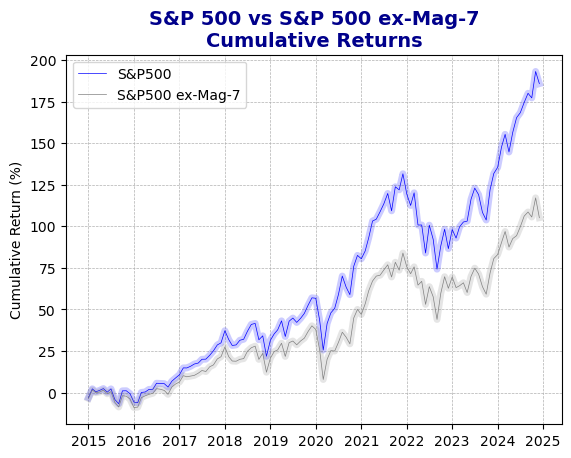

In [38]:
## Plot the S&P cumulative return and the S&P ex-Mag-7 cumulative return
fig, ax1 = plt.subplots()

sp500_cr = return_contributions.sp500_cr.mul(100) 
exmag7_cr = return_contributions.ex_mag7_cr.mul(100)

ax1.plot(sp500_cr.index.to_timestamp(), sp500_cr, linewidth=5, alpha=0.2, color='blue')
ax1.plot(sp500_cr.index.to_timestamp(), sp500_cr, label='S&P500', linewidth=0.5, color='blue')
ax1.plot(exmag7_cr.index.to_timestamp(), exmag7_cr, linewidth=5, alpha=0.2, color='grey')
ax1.plot(exmag7_cr.index.to_timestamp(), exmag7_cr, label='S&P500 ex-Mag-7', linewidth=0.5, color='grey')

ax1.set_title("S&P 500 vs S&P 500 ex-Mag-7\nCumulative Returns", fontweight='bold', fontsize=14, color='darkblue')
ax1.set_ylabel('Cumulative Return (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

plt.show()


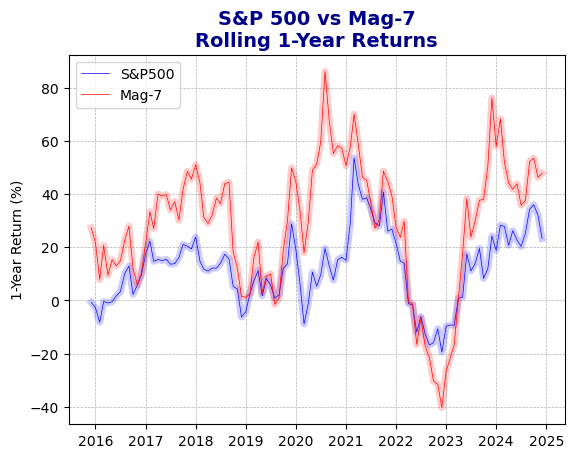

In [39]:
## Plot the S&P 500 rolling 1-year return and the Mag-7 rolling 1-year return
fig, ax2 = plt.subplots()
sp500_1y = return_contributions.sp500_1y.mul(100)
mag7_1y = return_contributions.mag7_1y.mul(100)

ax2.plot(sp500_1y.index.to_timestamp(), sp500_1y, linewidth=5, alpha=0.2, color='blue')
ax2.plot(sp500_1y.index.to_timestamp(), sp500_1y, label='S&P500', linewidth=0.5, color='blue')
ax2.plot(mag7_1y.index.to_timestamp(), mag7_1y, linewidth=5, alpha=0.2, color='red')
ax2.plot(mag7_1y.index.to_timestamp(), mag7_1y, label='Mag-7', linewidth=0.5, color='red')

ax2.set_title("S&P 500 vs Mag-7\nRolling 1-Year Returns", fontweight='bold', fontsize=14, color='darkblue')
ax2.set_ylabel('1-Year Return (%)')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()
plt.show()

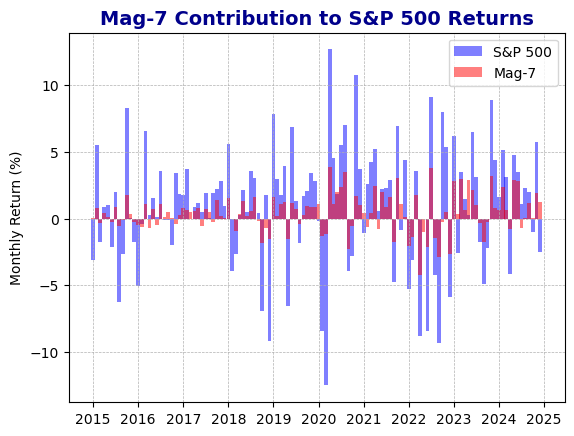

In [40]:
## Plot Mag-7 contribution to S&P 500 returns
fig, ax3 = plt.subplots()

sp500_mr = return_contributions.sp500.mul(100)
mag7_mr = return_contributions.mag7.mul(100)

width = pd.Timedelta(30, 'd')
ax3.bar(sp500_mr.index.to_timestamp(), sp500_mr, width=width, label='S&P 500', color='blue',alpha=0.5)
ax3.bar(mag7_mr.index.to_timestamp(), mag7_mr, width=width, label='Mag-7', color='red',alpha=0.5)

ax3.set_title("Mag-7 Contribution to S&P 500 Returns", fontweight='bold', fontsize=14, color='darkblue')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.set_ylabel('Monthly Return (%)')
ax3.legend()

plt.show()

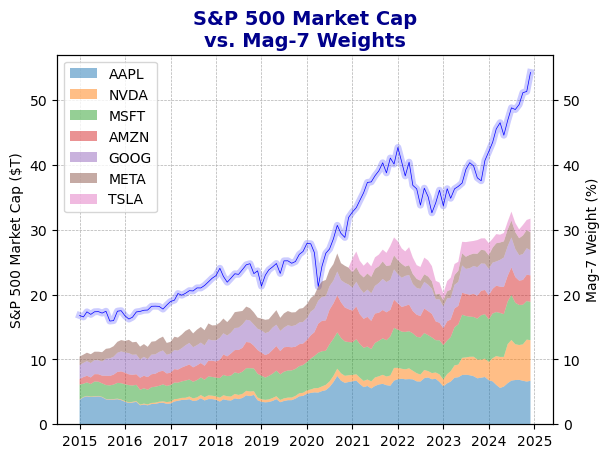

In [64]:
## Plot the market cap weights over time
fig, ax4 = plt.subplots()

sp500_mc = sp500.marketCap.div(1e3)

ax4.plot(sp500_mc.index.to_timestamp(), sp500_mc, label='S&P 500', linewidth=5, alpha=0.2, color='blue')
ax4.plot(sp500_mc.index.to_timestamp(), sp500_mc, label='S&P 500', linewidth=0.5, color='blue')

ax4.set_title("S&P 500 Market Cap\nvs. Mag-7 Weights", fontweight='bold', fontsize=14, color='darkblue')
ax4.set_ylabel('S&P 500 Market Cap ($T)')
ax4.set_ylim(0, 57)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

ax5 = ax4.twinx()

mag7_ordered = mag7_weights.loc[:, mag7_weights.iloc[-1].sort_values(ascending=False).index].mul(100)
cum_weights = mag7_ordered.iloc[:, 1]
ax5.fill_between(cum_weights.index.to_timestamp(), cum_weights, label=mag7_ordered.columns[1], alpha=0.5)
for i in range(2, len(mag7_ordered.columns)):
    ax5.fill_between(mag7_ordered.index.to_timestamp(), cum_weights.values, cum_weights.add(mag7_ordered.iloc[:,i]), label=mag7_ordered.columns[i], alpha=0.5)
    cum_weights = cum_weights.add(mag7_ordered.iloc[:,i])

ax5.set_ylim(0, ax4.get_ylim()[1])
ax5.set_ylabel('Mag-7 Weight (%)')
ax5.legend(loc='upper left')
plt.show()

In [ ]:
## Test for duplicate symbols (overstating market cap)
(
    market_caps
    .sum(axis=0)
    .round(2)
    .reset_index()
    .rename(columns={'index':'symbol', 0:'mc'})
    .loc[:, ['mc', 'symbol']]
    .groupby('mc')
    .agg({'symbol': list})
    .where(lambda df_: df_.symbol.map(len) > 1).dropna()
)

,symbol
mc,
